## State feedback and observer design (simple DC motor plant)

The main purpose of this boook is to learn the basics of Drake software. The focus is on 
how to define linear dynamical systems and construct a diagram for simulation. 3 fundamental types 
of system are addressed: static, continuous-time, and discrete time.

**Note :** For basic control tasks, it is easier to use Python Control Systems Library. 
Until we have all the state feedback and observer gains, together with plant and observer dynamics, 
then we formulate them as Drake system classes and construct a diagram for simulation.

In [3]:
#!pip install control==0.10.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

Matplotlib is building the font cache; this may take a moment.


In [2]:
ctl.__version__

'0.10.0'

### Problem 

We want to perform state feedback + observer control design and simulation 
on the robot joint driven by DC motor used previously 
in other notebooks. The reduced block diagrm is shown in Figure 1.

!["fig 1"](https://raw.githubusercontent.com/dewdotninja/sharing-github/master/ceb_m1_fig4.jpg)

Figure 1 reduced block diagram of robot joint dynmics

<p />with transfer function in the form

\begin{equation}
P(s) = \frac{1}{s(Js+B)} \tag{1}
\end{equation} 

<p />Let’s put some values to the parameters, say, J = 10, B = 0.1. Hence the resulting transfer function becomes

\begin{equation} 
P(s) = \frac{1}{10s^2 + 0.1s} \tag{2}
\end{equation}

In [3]:
s = ctl.tf("s")
P = 1/(10*s**2+0.1*s)
P

TransferFunction(array([1]), array([10. ,  0.1,  0. ]))

Observe Bode plot of this plant.

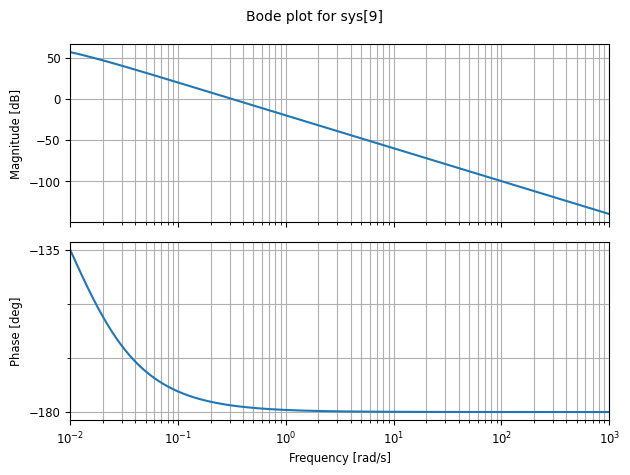

In [4]:
_ = ctl.bode_plot(P,dB=True, omega_limits=(0.01,1000))

Transform this plant to state-space representation amnd extract A,B,C,D matrices.

In [5]:
Pss = ctl.tf2ss(P)
A,B,C,D = ctl.ssdata(Pss)
print("A = {}".format(A))
print("B = {}".format(B))
print("C = {}".format(C))
print("D = {}".format(D))

A = [[-0.01 -0.  ]
 [ 1.    0.  ]]
B = [[1.]
 [0.]]
C = [[0.  0.1]]
D = [[0.]]


Note that we cannot perform state feedback directly on this plant because we don't know the 
physical meaning of all states and hence cannot measure them. So we must design an observer and 
use estimated states as feedback, as shown in Figure 2. 

!["fig 2"](https://raw.githubusercontent.com/dewdotninja/sharing-github/master/output_feedback.jpg)

Figure 2 output feedback control paradigm 

For this example, the reference command shaping block $G$ is omitted for simplicity. So our job is to 
design the state feedback gain $K$ and observer gain $L$. Both are static gain blocks. The design for 
each part could be done separately.

First consider the state feedback. Consult [module 5](https://github.com/dewdotninja/control_python/blob/main/ceb_m5.ipynb) 
of Control Engineering Basics on this github, for example. First, check whether the plant is controllable; 
i.e., the controllability matrix should have full rank, 2 in this case.


In [6]:
np.linalg.matrix_rank(ctl.ctrb(A,B))

2

Some ballpark specs.

1. overshoot less than 5%
2. rise time less than 0.1 sec

<p />Using relationshop of 2nd order system, we have that the specification 1 translates to 
damping ratio
$\zeta \ge 0.7$, and using the relation $t_r = 1.8/\omega_n$ , 
we have for specification 2 that $\omega_n \ge 18 $ rad/s. 
From the closed-loop characteristic polynomials  

\begin{equation} 
\Lambda(s) = s^2 + 2\zeta\omega_ns + \omega_n^2, \tag{3}
\end{equation} 



In [7]:
zeta = 0.7
wn = 18
lamda_s = (s**2 + 2*zeta*wn*s+wn**2)
desired_sfb_poles = ctl.zeros(lamda_s) # poles are roots of characteristic polynomial
print(desired_sfb_poles)

[-12.6+12.85457117j -12.6-12.85457117j]


Use either place() or acker() to compute the state feedback gain. 

In [8]:
K = ctl.place(A, B, desired_sfb_poles)
print(K)

[[ 25.19 324.  ]]


Check the poles of the closed-loop system to verify that they are in the desired locations.

In [9]:
Tss = ctl.ss(A-B@K, B, C, D)
ctl.poles(Tss)

array([-12.6+12.85457117j, -12.6-12.85457117j])

Verify the design by plotting the step response.

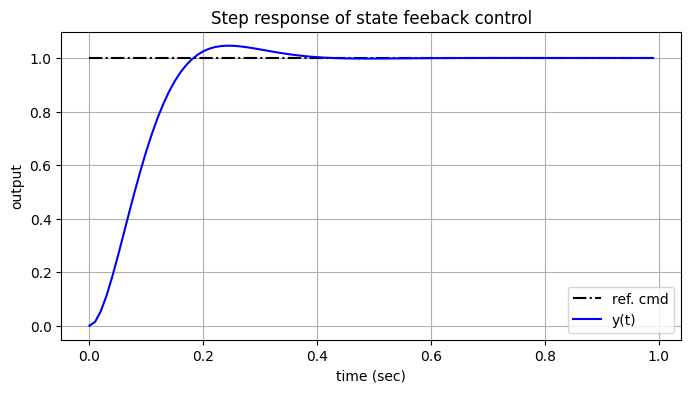

In [25]:
Kf=1/ctl.dcgain(Tss)
tvec = np.arange(0,1.0,0.01)
r = np.ones(tvec.shape)
rc = Kf*np.ones(tvec.shape)
_, y = ctl.forced_response(Tss, tvec, rc)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,y,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of state feeback control')
plt.show()

You may want to increase the natural frequency to improve rise-time (with the expense of larger 
controller output). For the purpose of this notebook, 
meeting the spec is not our primary concern. So we move on to design the observer.

First check that the system is observable.

In [11]:
np.linalg.matrix_rank(ctl.obsv(A,C))

2

The observer poles can be placed using similar steps as the state feedback design, only use 
matrix A and C. The observer poles should be placed further to the LHP, to achieve fast state estimation dynamics.   

In [12]:
desired_obs_poles = np.array([-100,-200])
L = ctl.place(A.T, C.T, desired_obs_poles)
L = L.T
print(L)

[[199970.001]
 [  2999.9  ]]


Check the closed-loop observer poles whether they match desired pole locations.

In [13]:
Oss = ctl.ss(A-L@C, B, C, D)
ctl.poles(Oss)

array([-100.+0.j, -200.+0.j])

The closed-loop system of state feedback with observer is governed by

\begin{equation} 
\left[ \begin{array}{c}
\dot{x} \\
\dot{\tilde{x}} 
\end{array}  \right] = 
\left[ \begin{array} {cc}
A-BK & BK \\
0 & A-LC
\end{array} \right]
\left[ \begin{array}{c}
x \\
\tilde{x}
\end{array} \right] + 
\left[ \begin{array}{c}
BK_f \\
0 
\end{array} \right] u \tag{3}
\end{equation} 

and 

\begin{equation}
y = \Big[C \;\;\; 0\Big]\left[ \begin{array}{c}
x \\
\tilde{x} 
\end{array}  \right] \tag{4}
\end{equation} 

Construct this system to simulate closed-loop step response. We can see that the output feedback control matches the 
original state-feedback quite well.


In [14]:
n_states = 2
A_cl_upper = np.hstack((A-B@K, B@K))
A_cl_lower = np.hstack((np.zeros((n_states,n_states)),A - L@C))
A_cl = np.vstack((A_cl_upper,A_cl_lower))
B_cl = np.vstack((B*Kf,np.zeros((n_states,1))))
C_cl = np.hstack((C,np.zeros((1,n_states))))
D_cl = [0]
Tss_cl = ctl.ss(A_cl, B_cl, C_cl, D_cl)

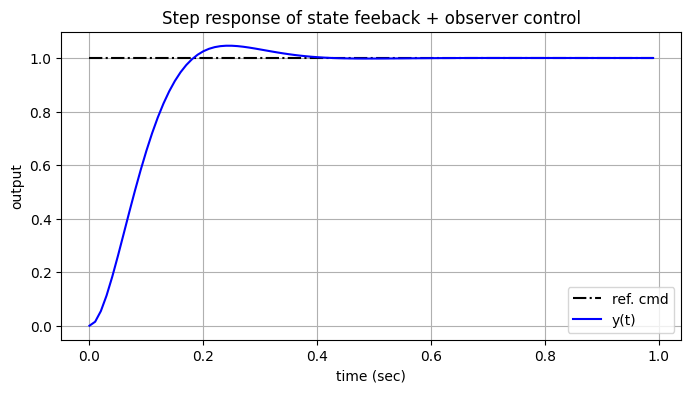

In [26]:
tvec = np.arange(0,1.0,0.01)
r = np.ones(tvec.shape)
_, y_sfo = ctl.step_response(Tss_cl, tvec)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,y_sfo,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of state feeback + observer control')
plt.show()

Now, we want to do something a little different here. That is, the observer dynamics is 
constructed in discrete-time. The only reason is to construct hybrid diagram in Drake later, consisting 
of continous-time and discrete-time systems, and see wheter simulation can be performed for such diagram.

Convert the continuous-time plant to discrete-time with sampling period Ts.

In [16]:
Ts = 0.01 # sampling period
Pdss = ctl.c2d(Pss,Ts,method='tustin')
Ad,Bd,Cd,Dd = ctl.ssdata(Pdss)
print("Ad = {}".format(Ad))
print("Bd = {}".format(Bd))
print("Cd = {}".format(Cd))
print("Dd = {}".format(Dd))

Ad = [[0.9999    0.       ]
 [0.0099995 1.       ]]
Bd = [[9.99950002e-03]
 [4.99975001e-05]]
Cd = [[0.00049998 0.1       ]]
Dd = [[2.49987501e-06]]


Compute the discrete-time desired locations of the observer.

In [17]:
desired_DT_obs_poles = np.exp(desired_obs_poles*Ts)
desired_DT_obs_poles

array([0.36787944, 0.13533528])

Then compute the observer gain vector.

In [18]:
Ld = ctl.place(Ad.T, Cd.T, desired_DT_obs_poles)
Ld = Ld.T
print(Ld)

[[546.47732655]
 [ 12.23460279]]


**Optional :** If we want to design state feedback in discrete-time, we can do so as well.

In [19]:
zeta = 0.7
wn = 18
lamda_s = (s**2 + 2*zeta*wn*s+wn**2)
desired_sfb_poles = ctl.zeros(lamda_s) # poles are roots of characteristic polynomial
print(desired_sfb_poles)

[-12.6+12.85457117j -12.6-12.85457117j]


In [20]:
# find discrete-time state feedback gain
desired_DT_sfb_poles = np.exp(desired_sfb_poles*Ts)
print(desired_DT_sfb_poles)
Kd = ctl.place(Ad, Bd, desired_DT_sfb_poles)
print(Kd)

[0.87434097+0.11301596j 0.87434097-0.11301596j]
[[ 23.69485135 285.6422755 ]]


In [21]:
# check closed-loop poles and find discrete-time feedforward gain
Tdsf_ss = ctl.ss(Ad-Bd@Kd, Bd, Cd, Dd,Ts)  # don't forget the sampling time argument!
Kdsf=1/ctl.dcgain(Tdsf_ss)
ctl.poles(Tdsf_ss)

array([0.87434097+0.11301596j, 0.87434097-0.11301596j])

In [22]:
Kdsf

2836.1705126697066

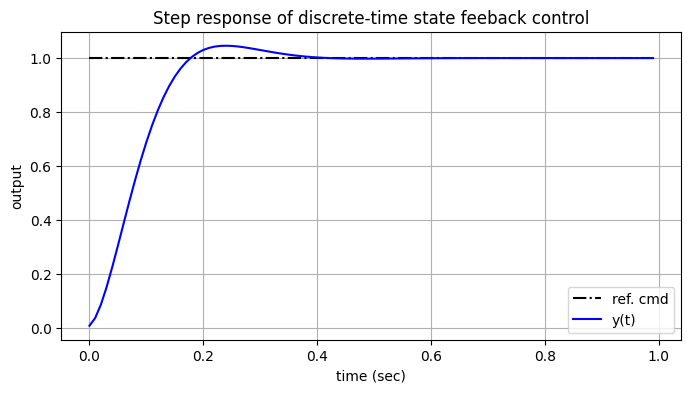

In [27]:
# step response of discrete-time state feedback system
tvec = np.arange(0,1,Ts)
r = np.ones(tvec.shape)
rdc = Kdsf*np.ones(tvec.shape)
tdvec, ydsf = ctl.forced_response(Tdsf_ss,tvec,rdc)
r = np.ones(tdvec.shape)
plt.figure(figsize=(8,4))
plt.plot(tdvec,r,'k-.',tdvec,ydsf,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of discrete-time state feeback control')
plt.show()


Simulation of the discrete-time output feedback system can be done the same way as before.

In [29]:
num_states = Ad.shape[0]
Ad_cl_upper = np.hstack((Ad-Bd@Kd, Bd@Kd))
Ad_cl_lower = np.hstack((np.zeros((num_states,num_states)),Ad - Ld@Cd))
Ad_cl = np.vstack((Ad_cl_upper,Ad_cl_lower))
Bd_cl = np.vstack((Bd*Kdsf,np.zeros((num_states,1))))
Cd_cl = np.hstack((Cd,np.zeros((1,num_states))))
Dd_cl = [0]
Tdss_cl = ctl.ss(Ad_cl, Bd_cl, Cd_cl, Dd_cl,Ts)

Check stability of discrete-time closed loop system. All poles must lie within unit circle.

In [30]:
abs(ctl.poles(Tdss_cl))

array([0.88161485, 0.88161485, 0.36787944, 0.13533528])

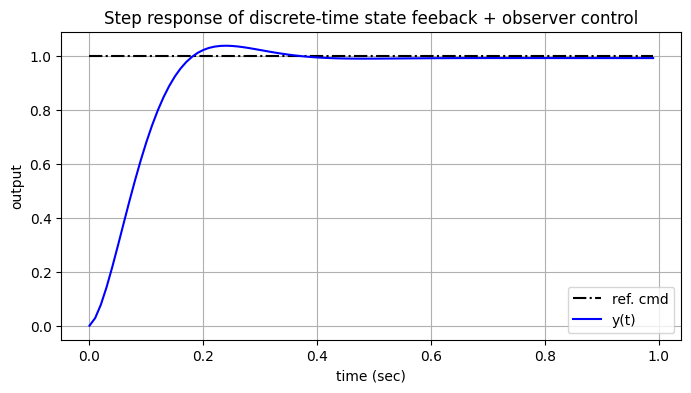

In [32]:
tdvec = np.arange(0,1,Ts)
rd = np.ones(tdvec.shape)
_, yd_sfo = ctl.step_response(Tdss_cl, tdvec)
plt.figure(figsize=(8,4))
plt.plot(tdvec,rd,'k-.',tdvec,yd_sfo,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of discrete-time state feeback + observer control')
plt.show()

We are now ready to build a diagram in Figure 2 using Drake. To simplify the diagram, we 
redraw it as subsystem connection just like in Figure 3. 

!["fig 3"](https://raw.githubusercontent.com/dewdotninja/sharing-github/master/sfb_obs_diagram.png)

Figure 3 simplified output feedback diagram 

This diagram is a mixture of static and continuous-time and discrete-time dynamical subsystems 
that we have to define. The step input subsystem is available in Drake. 

**Note :** Make sure you have Drake installed as instructed on the 
[Drake website](https://drake.mit.edu/). 

First import all the required Drake API. 



In [33]:
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, BasicVector, LeafSystem
from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource, LinearSystem

Start from the easiest one: the static state feedback control. As the name implies, this class has no state. The output is computed from the 
reference command subtracted by feedback from the estimated state. The state feedback gain is provided as argument during initialization, together 
with feedforward gain. The latter is needed to drive plant output to 1. 

In [34]:
class StaticSFB(LeafSystem):
    def __init__(self,K, Kf):
        self.nstates = K.shape[1]
        super().__init__()  # Don't forget to initialize the base class.
        self.r = self.DeclareVectorInputPort(name="r", size=1)  # ref.cmd input
        self.xhat = self.DeclareVectorInputPort(name="xhat", size=self.nstates) # estimated state input
        self.DeclareVectorOutputPort(name="controlout", size=1, calc=self.CalcControlOutput)
        self.K = K  # state feedback gain
        self.Kf = Kf  # DC gain is needed so that output steps to 1

    def CalcControlOutput(self, context, output):
        r = self.r.Eval(context)  # evaluate ref.cmd
        xhat = self.xhat.Eval(context) # evaluate estimated state input
        u = self.Kf*r - self.K @ xhat
        output.SetFromVector(u)


The second subsystem is continuous-time plant. The A,B,C matrix is inputted as argument during initialization. The main difference from static 
subsystem is now we need to define the dynamical system that govens the plant in DoCalcTimeDerivatives(). 
(This name cannot be changed.) Later on, we can put general nonlinear dynamics in this function. But for this example, the plant dynamics is just 
xdot = Ax + Bu. 
Then, the output method must be defined, and the output is computed as y = Cx. (In general, y = Cx + Du but we know that D = 0)

In [35]:
class CTPlant(LeafSystem):
    def __init__(self,A,B,C): # D is not needed since it is 0 for physical system
        super().__init__()
        num_state = A.shape[0] # extract proper dimension from A,B,C
        num_input = B.shape[1]
        num_output = C.shape[0]
        self.DeclareContinuousState(num_state)  # One state variable.
        self.DeclareVectorInputPort("u",BasicVector(num_input))
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY)
        # plant SS data
        self.A = A
        self.B = B
        self.C = C

    def DoCalcTimeDerivatives(self, context, derivatives):
        # get the state
        x = context.get_continuous_state_vector().CopyToVector()
        # get the input
        u = self.get_input_port(0).Eval(context)        
        xdot = self.A @ x + self.B @ u
        derivatives.get_mutable_vector().SetFromVector(xdot)

    def CalcOutputY(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = self.C @ x
        output.SetFromVector(y)

The third subsystem is the discrete-time observer. 

In [36]:
class DTObserver(LeafSystem):
    def __init__(self,Ad,Bd,Cd,Ld, Ts):
        super().__init__()
        num_DTstate = Ad.shape[0] # extract proper dimension from A,B,C
        num_input1 = Bd.shape[1]
        num_input2 = Cd.shape[0]
        num_output = Ad.shape[0]
        self.Ad = Ad
        self.Bd = Bd
        self.Cd = Cd
        self.Ld = Ld  # estimator gain
        self.Ts = Ts  # sampling period

        
        self.DeclareDiscreteState(num_DTstate)  # num_state state variable.
        self.u = self.DeclareVectorInputPort("u", BasicVector(num_input1))  
        self.y = self.DeclareVectorInputPort("y", BasicVector(num_input2))  
        
        self.DeclareVectorOutputPort("xhat", BasicVector(num_output), 
                            self.CalcXhat, set([self.all_state_ticket()])) # last argument required to avoid
                                                                            # algebraic loop
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=self.Ts,  # sampling time
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().CopyToVector()
        u = self.u.Eval(context)
        y = self.y.Eval(context)
        #x = np.mat(x.reshape((5,1)))
        xnext = (self.Ad - self.Ld@self.Cd)@x +self.Bd@u + self.Ld@y
        discrete_state.get_mutable_vector().SetFromVector(xnext)

    def CalcXhat(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        y = x  # just output the estimated state
        output.SetFromVector(y)

In [37]:
builder = DiagramBuilder()
SFB_control = builder.AddSystem(StaticSFB(K,Kf))  # state-feedback subsystem
CT_plant = builder.AddSystem(CTPlant(A,B,C)) # continuous-time HDM plant
DT_observer = builder.AddSystem(DTObserver(Ad,Bd,Cd,Ld,Ts)) # discrete-time observer
stepInput = builder.AddSystem(ConstantVectorSource([1]))  # step-input. 
builder.Connect(stepInput.get_output_port(0), SFB_control.get_input_port(0)) # step input to SFB input 0
builder.Connect(DT_observer.get_output_port(0), SFB_control.get_input_port(1)) # observer output to SFB input 1
builder.Connect(SFB_control.get_output_port(0), CT_plant.get_input_port(0)) # SFB output to plant input 1
builder.Connect(SFB_control.get_output_port(0),DT_observer.get_input_port(0))  # SFB output to observer input 0
builder.Connect(CT_plant.get_output_port(0), DT_observer.get_input_port(1))  # plant output to observer input 1

logger_output = LogVectorOutput(CT_plant.get_output_port(0), builder)
logger_input = LogVectorOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()


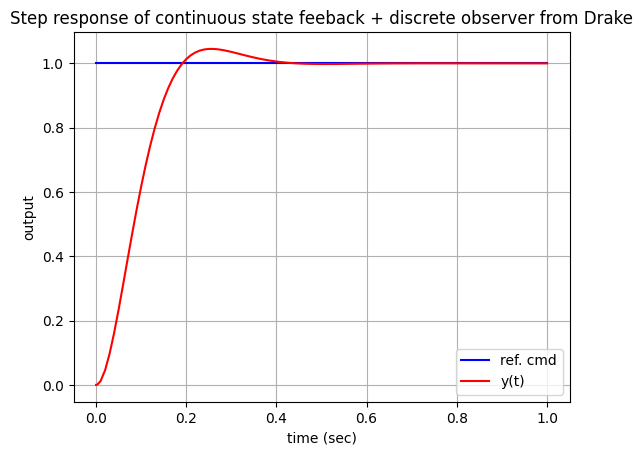

In [39]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()  # overall context 

# subsystem context 
plant_context = diagram.GetMutableSubsystemContext(CT_plant, context)
plant_context.SetContinuousState([0,0])
observer_context = diagram.GetMutableSubsystemContext(DT_observer, context)
observer_context.SetDiscreteState([0,0])
# create the simulator
#simulator = Simulator(diagram, context)
simulator.AdvanceTo(1)
log_output = logger_output.FindLog(context)
log_input = logger_input.FindLog(context)

# Plot the results.
plt.figure()
plt.plot(log_input.sample_times(),log_input.data().transpose(),'b-',
         log_output.sample_times(), log_output.data().transpose(),'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of continuous state feeback + discrete observer from Drake')
plt.show()

<div align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</div>
<div align="center">dew.ninja 2024</div>